### 1. Imports

In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import json

from utils.config import PART_COLORS
from utils.mask_utils import load_mask
from utils.camera_estimation import visualize_voxel_projection_iou
from utils.deformation_estimation import launch_deform_viewer_fixed_camera

### 2. Load data

Voxel: (128, 79, 128, 3) | Front: (79, 128, 3) | Drone: (337, 491, 3)


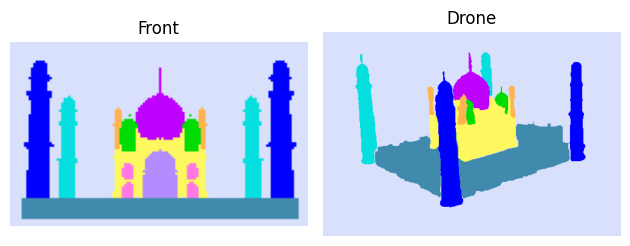

In [8]:
root = Path.cwd()
data = root / "data"
monument = ["Akbar","Bibi","Charminar","Itimad","Taj"][1]

voxel_grid = np.load(
    root/"results_temp/1.Orthographic_Voxel_Carving"/f"{monument}_voxel_grid.npz"
)["voxel_grid"]
max_dim = np.max(voxel_grid.shape)

front_mask = load_mask(data, monument, "front", max_dim)
drone_mask = load_mask(data, monument, "drone")

print("Voxel:", voxel_grid.shape,
      "| Front:", front_mask.shape,
      "| Drone:", drone_mask.shape)

for i,(t,m) in enumerate([("Front",front_mask),("Drone",drone_mask)]):
    plt.subplot(1,2,i+1); plt.imshow(m); plt.title(t); plt.axis("off")
plt.tight_layout(); plt.show()

camera_results = json.load(open(
    root/"results_temp/2.Perspective_Camera_Estimation"/f"{monument}_camera_params_final.json"
))

# Convert loaded camera params (JSON) into NumPy arrays
# ------------------------------------------------------------
def to_numpy(obj):
    if isinstance(obj, list):
        return np.array(obj, dtype=np.float32)
    if isinstance(obj, dict):
        return {k: to_numpy(v) for k, v in obj.items()}
    return obj

camera_results = to_numpy(camera_results)

### 3. Deform

In [10]:
## Views for deformation
views = {
    "front": {
        "mask": front_mask,
        "labels": [PART_COLORS['front_minarets'], PART_COLORS['back_minarets']],
    },
    "drone": {
        "mask": drone_mask,
        "labels": [PART_COLORS['front_minarets'], PART_COLORS['back_minarets']],
    }
}

view = 'drone' # 'drone' #'front'
voxel_padded = np.pad(voxel_grid, ((0, 0), (0, 0), (0, 0), (0, 0)), constant_values=0)

init_params_deform = {
 'chhatri': {'deform': {'scale_y': 1.0, 'shift_y': 0.0, 'scale_xz': 1.0, 'shift_xz': 0.0}, 'iou': 0.0},
 'windows': {'deform': {'scale_y': 1.0, 'shift_y': 0.0, 'scale_xz': 1.0, 'shift_xz': 0.0}, 'iou': 0.0},
 'mainbuilding': {'deform': {'scale_y': 1.0, 'shift_y': -1.0, 'scale_xz': 1.0, 'shift_xz': 0.0}, 'iou': 0.0}
}

deform_results, grid_store = launch_deform_viewer_fixed_camera(
    voxel_padded,
    PART_COLORS,
    image=views[view]['mask'],
    cam_params=camera_results[view],
    part_names=list(PART_COLORS.keys()),
    init_params=init_params_deform  # optional
)



Visualizing combined binary projection vs. binary ground-truth...


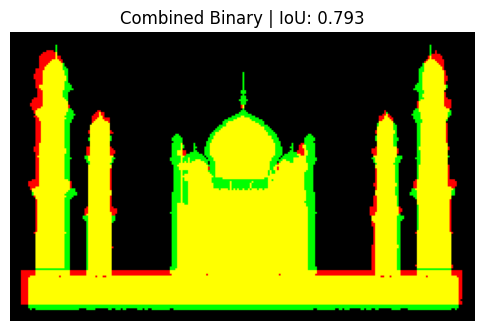

In [5]:
deformed_grid = grid_store['grid']
visualize_voxel_projection_iou(deformed_grid, PART_COLORS, image=views[view]['mask'], cam_params=camera_results[view], mode='whole_on_whole')

### 4. Save deformed grid

In [ ]:
RESULTS_SRC   = "results_temp"   # or "results"

# --- Path ---
save_path = (
    root
    / RESULTS_SRC
    / "3.Part-wise_3D_Refinement"
    / f"{monument}_deformed_voxel_grid.npz"
)

save_path.parent.mkdir(parents=True, exist_ok=True)

# --- Save ---
np.savez_compressed(save_path, voxel_grid=deformed_grid)

print("Deformed voxel grid saved to:", save_path.resolve())